In [1]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.sparse import hstack
import nltk as nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from IPython.display import clear_output
import matplotlib.pyplot as plt
from gensim.matutils import any2sparse
from gensim.models import LdaModel

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Loading files
train_files = [
    'data/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [3]:
## Loading data from JSON
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding='UTF-8') as handle:
            dataf = json.load(handle)
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        train_text.extend(dataf_text)
        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        train_labels.extend(dataf_labels)
    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [4]:
# Split the data into training, validation, testing sets.

from sklearn.model_selection import train_test_split

# Split test data from training data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train_tweets, val_documents, train_labels, val_labels = train_test_split(
    train_tweets, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels
)

print(f'Number of training instances = {len(train_tweets)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_tweets)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [5]:
# Print example tweet
print(f'What does one instance look like from the training set? \n\n{train_tweets[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

Standard Chartered, RBS Escape Capital Raising in Stress Test
...and here is its corresponding label 

2


# 1. Preprocessing using  lemmatization
We create a lemmatizer tokenizer that reduces words to their root forms. This reduces the vocabulary size.

In [6]:
# We create a lemmaTokenizer class that applies lemmatization when tokenizing.
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, tweets):
        return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(tweets)]
    

# 2.1 Using bi-grams + unigrams as feature
We apply our tokenizer and set it to allow ngram features (both unigrams and bigrams). 

In [7]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2))
vectorizer.fit(train_tweets)
X_train = vectorizer.transform(train_tweets)
X_val = vectorizer.transform(val_documents)
X_test_tweets = vectorizer.transform(test_tweets)
# Let's look at some of the features.
print(list(vectorizer.vocabulary_)[:10])

C:\Users\adnan\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['$', 'fb', 'turn', 'back', 'down', 'in', 'early', 'trade', '....', 'http']


In [8]:
# Checking full vocabulary size:
print(f' Full vocabulary size: {len(vectorizer.vocabulary_)}')
vocabulary = vectorizer.vocabulary_

 Full vocabulary size: 10682


              precision    recall  f1-score   support

           0       0.70      0.52      0.60        50
           1       0.43      0.10      0.16        31
           2       0.66      0.91      0.76        97

    accuracy                           0.66       178
   macro avg       0.60      0.51      0.51       178
weighted avg       0.63      0.66      0.61       178



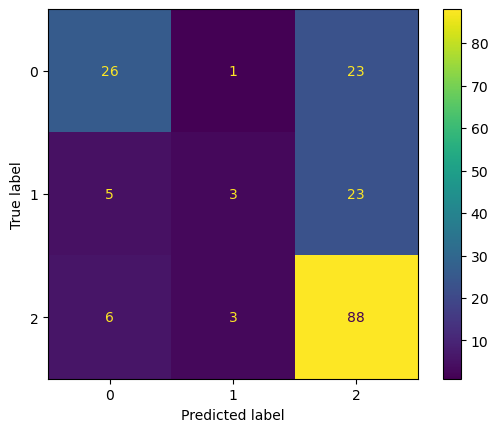

In [9]:
# Now let's fit our data to the model.
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

# Using POS-NEG lexicon features

In [10]:
# instantiate analyzer
analyser = SentimentIntensityAnalyzer()
# fetch vocabulary
vocabulary = vectorizer.vocabulary_
# create empy holders for lexicon scores.
lexicon_pos_scores = np.zeros((1, len(vocabulary)))
lexicon_neg_scores = np.zeros((1, len(vocabulary)))

for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lexicon_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lexicon_neg_scores[0, i] = 1

In [11]:
# This enables us to get the total positive and total negative counts for each set:
lexicon_pos_train = np.sum(X_train.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_val = np.sum(X_val.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_test = np.sum(X_test_tweets.multiply(lexicon_pos_scores), axis=1)

lexicon_neg_train = np.sum(X_train.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_val = np.sum(X_val.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_test = np.sum(X_test_tweets.multiply(lexicon_neg_scores), axis=1)

In [12]:
X_train = hstack((X_train, lexicon_pos_train, lexicon_neg_train))
X_val = hstack((X_val, lexicon_pos_val, lexicon_neg_val))
X_test_tweets = hstack((X_test_tweets, lexicon_pos_test, lexicon_neg_test))

              precision    recall  f1-score   support

           0       0.72      0.52      0.60        50
           1       0.43      0.10      0.16        31
           2       0.66      0.92      0.77        97

    accuracy                           0.66       178
   macro avg       0.60      0.51      0.51       178
weighted avg       0.64      0.66      0.62       178



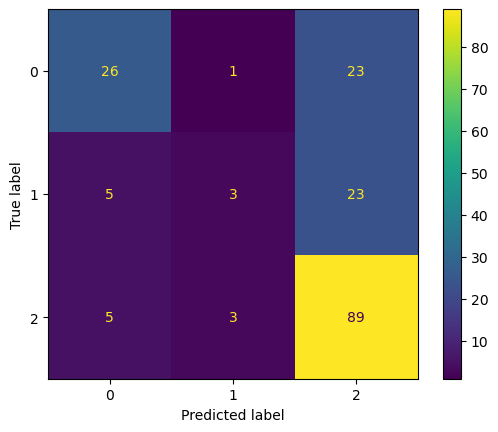

In [13]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
# Checking performance
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

In [14]:
# Key part is investigating the errors by looking at the actual values, so let's do that:
error_indexes = y_val_pred != val_labels  # let's compare predictions to true values for labels

# get the tweets where the classifier made an error:
tweets_err = np.array(val_documents)[error_indexes]

pred_err = y_val_pred[error_indexes]
true_err = np.array(val_labels)[error_indexes]

for i in range(10):
    print(f'Tweet: {tweets_err[i]}; true label = {true_err[i]}, prediction = {pred_err[i]}.')

Tweet: $ISRG - ISRG Short - http://stks.co/f1vVU http://stks.co/c1qrm; true label = 0, prediction = 2.
Tweet: Standard Chartered lags on capital worries; true label = 0, prediction = 2.
Tweet: UPDATE 1-SABMiller 2nd-quarter underlying sales rise, forex impacts margins; true label = 1, prediction = 2.
Tweet: Tesco closes in on new chairman with Dixons Carphone's John Allan in the frame; true label = 1, prediction = 2.
Tweet: RT @andrewnyquist Chartology: Yahoo: http://stks.co/1itr $YHOO  Crazy looking chart, but nearing breakout resistance line...; true label = 1, prediction = 2.
Tweet: @Joerazorback This time I think $AAPL will miss again. Generally speaking market is near top when everyone thinks that market goes only up; true label = 0, prediction = 2.
Tweet: RBS will reportedly appoint Howard Davies as its next chairman; true label = 1, prediction = 0.
Tweet: That bearish outside day Tuesday is significant. 200 day resistance still intact. just my opinion $SDS http://chart.ly/2bey48

# Performance on test set

              precision    recall  f1-score   support

           0       0.71      0.47      0.56        62
           1       0.50      0.13      0.20        39
           2       0.65      0.91      0.76       122

    accuracy                           0.65       223
   macro avg       0.62      0.50      0.51       223
weighted avg       0.64      0.65      0.61       223



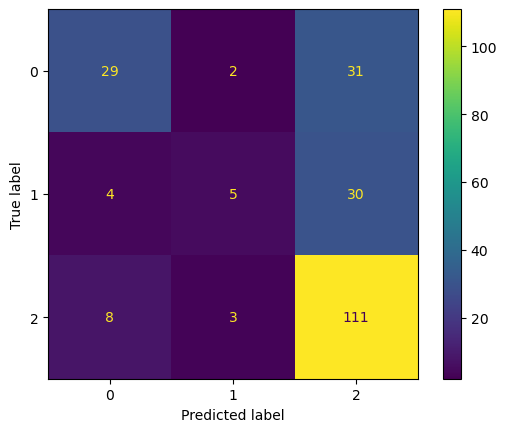

In [15]:
# Let's test the performance on the test set.
y_test_pred = classifier.predict(X_test_tweets)
# Checking performance
cm = confusion_matrix(test_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(test_labels, y_test_pred))

# 4. Extracting topics using LDA

In [16]:
# First let's get another clean split of the data. 
from sklearn.model_selection import train_test_split

# Split test data from training data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train_tweets, val_tweets, train_labels, val_labels = train_test_split(
    train_tweets, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels 
)

print(f'Number of training instances = {len(train_tweets)}')
print(f'Number of validation instances = {len(val_tweets)}')
print(f'Number of test instances = {len(test_tweets)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [17]:
 # We use the function below for tokenization. Does a number of things, including removing small words, deleting words with special chars,  changing uppercase to lowercase, and more.
def preprocess(text):
    final_results=[]
    for token in simple_preprocess(text) : 
        if token not in STOPWORDS:
            final_results.append(WordNetLemmatizer().lemmatize(token, 'v'))
    return final_results

# Create a list of preprocessed documents
processed = []
for doc in train_tweets:
    processed.append(preprocess(doc))
print(processed)

[['bbry', 'ready'], ['tesco', 'sell', 'blinkbox', 'broadband', 'service', 'talktalk'], ['tesco', 'share', 'jump', 'christmas', 'sales', 'beat', 'expectations'], ['pg', 'ackman', 'make', 'big', 'add', 'efficiency', 'argument', 'bet', 'operational', 'imporvement', 'huge', 'conglomerate', 'way', 'imo'], ['linkedin', 'revenue', 'nearly', 'http', 'stks', 'lnkd'], ['dmnd', 'green', 'move'], ['tsla', 'recall'], ['aldi', 'lidl', 'expansion', 'plan', 'speed', 'ahead', 'tesco', 'sainsbury', 'morrisons'], ['apple', 'rip', 'roar', 'rally', 'begin', 'aapl', 'investorplace', 'aapl', 'https', 'jrcfc', 'xly'], ['london', 'stock', 'exchange', 'seal', 'billion', 'merger', 'germany', 'deutsche', 'bã', 'rse'], ['severn', 'trent', 'share', 'price', 'jump', 'canadian', 'investor', 'renew', 'pursuit', 'utility'], ['netflix', 'grow', 'efforts', 'create', 'loyal', 'customers', 'nflx', 'https', 'qxbkobphe'], ['buyback', 'trend', 'right', 'cpix', 'spend', 'share', 'pricier', 'hopefully', 'pull', 'close', 'vwap']

In [18]:
from gensim.corpora import Dictionary
# create a dictionary of word:id key/val pairs.
dictionary = Dictionary(processed) 
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary(2339 unique tokens: ['bbry', 'ready', 'blinkbox', 'broadband', 'sell']...)


In [19]:
# Getting means of thetas and training the LDA.



lda_model =  LdaModel(bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

def get_tweet_topic_dists(tweets, lda_model):
    thetas = []
    for i in range(len(tweets)):
        # Get the tweet
        unseen_tweet = tweets[i]

        # Preprocess for bag of words:
        bow_vector = dictionary.doc2bow(preprocess(unseen_tweet))

        # Let's get the topic distribution:
        theta_tweet = lda_model[bow_vector]

        thetas.append(theta_tweet)

    return thetas

thetas = get_tweet_topic_dists(val_tweets, lda_model)

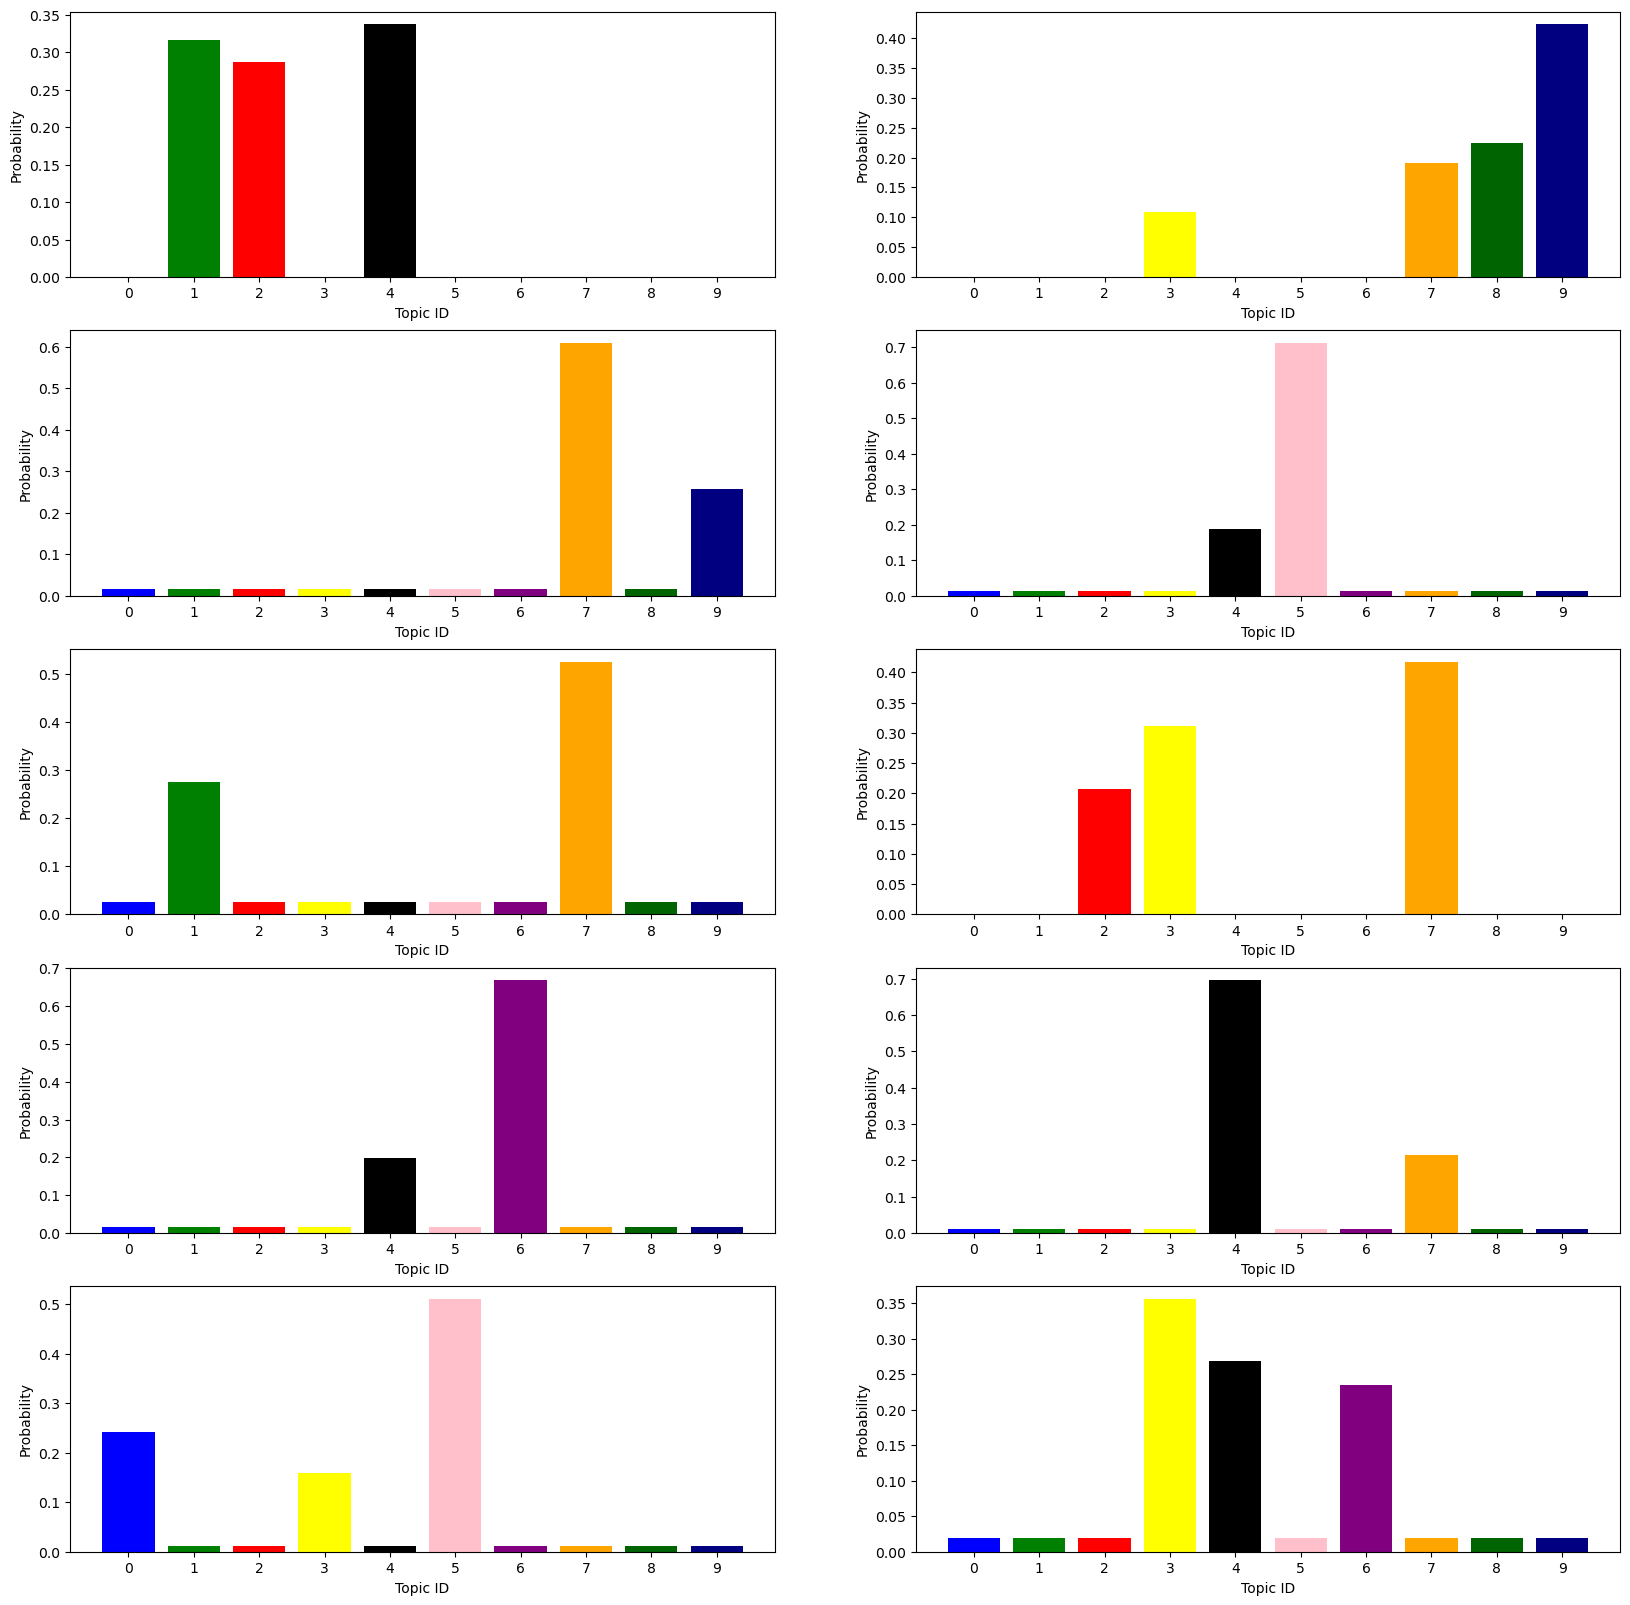

In [30]:

# We will use colours to represent topics.
colours = ['blue', 'green', 'red', 'yellow', 'black', 'pink', 'purple',
           'orange',  'darkgreen',  'navy', 'crimson']

def convert_theta_sparse_to_dense_vector(theta_dist_sparse, num_topics):
    theta_dist = np.zeros(num_topics)
    
    # get active topics
    active_topics_for_dist, probs = map(list, zip(*theta_dist_sparse))
    
    # add to thetas_dist
    for i, topic in enumerate(active_topics_for_dist):
        if topic >= num_topics:
            break
            
        theta_dist[topic] = probs[i]
    
    return theta_dist

# Create barchart
def plot_theta(thetas, i, num_tweets, num_topics):
    plt.subplot(int((num_tweets+1)/2), 2, i+1)
    theta_dist = convert_theta_sparse_to_dense_vector(thetas[i], num_topics)
    plt.bar(x=np.arange(len(theta_dist)), height=theta_dist, color=colours, tick_label=np.arange(num_topics))
    plt.xlabel("Topic ID")
    plt.ylabel("Probability")
plt.figure(figsize=(20,20))

num_tweets = 10
num_topics = 10
counter = 0
for i, theta in enumerate(thetas):
    if (counter < 10):
        plot_theta(thetas, i, num_tweets, num_topics)
        counter +=1
plt.show()

# Visualizing topic distributions across labels using validation set

In [21]:
# Merge arrays for later 
arr = val_tweets
arr_2 = val_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

[['Should You Buy Jumbo Yielders British American Tobacco plc, Centrica PLC & John Wood Group PLC?'
  '1']
 ["UPDATE 5-SABMiller rejects AB InBev's $104 bln takeover approach" '1']
 ["Kraft, Cadbury's and Britvic in Total Recall: how pulling a product affects profit"
  '1']
 ['CompaniesDixons Carphone to close 134 UK stores as sales jump' '1']
 ["$ENDP Was looking for a long entry but today's price action wasn't appealing"
  '1']
 ['volatility squeeze in $AAPL. I hope it gets resolved to the upside'
  '1']
 ['UPDATE 3-BP settles oil spill-related claims with Halliburton, Transocean'
  '1']
 ['$UBNT still having some trouble at the resistance line. Should resolve soon.@cheri1 @strattonite   http://stks.co/c0sU4'
  '1']
 ['Morrisons faces festive sales test' '1']
 ["ITV to pursue takeover of Canada's Entertainment One: Bloomberg" '1']
 ["SAB's Chairman Digs In With Board Divided on InBev Offer" '1']
 ["stole my tweet. really wouldn't be surprised if we took out 423 and pinned around it R

In [22]:
# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_tweet_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_tweet_topic_dists
        thetas_t_sparse = get_tweet_topic_dists(val_tweets[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense_vector(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_tweet_mean_topics()

print(mean_arr.shape)

[0.04912958 0.03632942 0.14885367 0.10065465 0.15931027 0.06997272
 0.11982704 0.09507175 0.07785998 0.13929191]
[0.07836627 0.09693413 0.08084594 0.0859022  0.10046943 0.15936484
 0.11441073 0.14439243 0.07349517 0.05630845]
[0.05994237 0.07448401 0.13144083 0.08731273 0.14380349 0.08150338
 0.08846017 0.0990821  0.0775006  0.15119222]
(3, 10)


[0.06351355 0.07716996 0.16216769 0.08490182 0.0983273  0.07650069
 0.09703376 0.11462563 0.12968157 0.09039456]
[0.05883501 0.10997727 0.17542948 0.06835977 0.11455249 0.09766516
 0.08979549 0.07950518 0.10133709 0.10057976]
[0.07855283 0.09775347 0.14394986 0.0703766  0.11095901 0.05576761
 0.08784511 0.08040146 0.09880889 0.17043727]


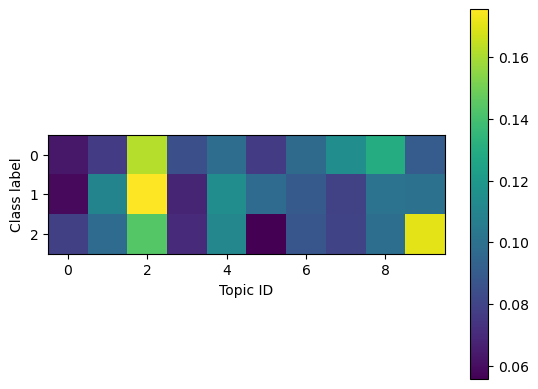

In [28]:
def plot_tweet_topic_matrix():
    # Get mean tweet topics dists
    mean_thetas = get_tweet_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.xlabel("Topic ID")
    plt.ylabel("Class label")
    plt.show()
plot_tweet_topic_matrix()

In [24]:
# For each topic, let's show the words occuring in that topic, so we can identify it.
for topic_id, topic in lda_model.print_topics(-1):
    print("Topic ID: {} \nAssociated Words:\n {}".format(topic_id, topic ))
    print("\n")

Topic ID: 0 
Associated Words:
 0.011*"sell" + 0.011*"https" + 0.010*"share" + 0.008*"sabmiller" + 0.007*"call" + 0.007*"stock" + 0.007*"lower" + 0.007*"company" + 0.007*"rat" + 0.007*"bid"


Topic ID: 1 
Associated Words:
 0.009*"share" + 0.008*"aapl" + 0.007*"sales" + 0.007*"market" + 0.007*"sell" + 0.006*"boost" + 0.006*"company" + 0.006*"price" + 0.006*"add" + 0.006*"merger"


Topic ID: 2 
Associated Words:
 0.020*"break" + 0.018*"aapl" + 0.013*"stks" + 0.013*"http" + 0.013*"long" + 0.010*"https" + 0.009*"look" + 0.008*"run" + 0.007*"short" + 0.006*"buy"


Topic ID: 3 
Associated Words:
 0.014*"plc" + 0.012*"price" + 0.011*"sales" + 0.010*"share" + 0.009*"tesco" + 0.009*"http" + 0.009*"stks" + 0.009*"group" + 0.009*"continue" + 0.007*"year"


Topic ID: 4 
Associated Words:
 0.017*"look" + 0.012*"tsla" + 0.012*"stks" + 0.012*"http" + 0.009*"recall" + 0.009*"https" + 0.008*"profit" + 0.008*"like" + 0.007*"get" + 0.007*"come"


Topic ID: 5 
Associated Words:
 0.013*"short" + 0.008*"ne

# Using test set

[['Tesco Abandons Video-Streaming Ambitions in Blinkbox Sale' '1']
 ['$AMZN trades in mid to upper range. No break out yet, either direction'
  '1']
 ['METALS-Zinc surges 12 pct after Glencore cuts output, fuelling metals rally'
  '1']
 ['$CNP Sell Short Position on CNP,...Closed for Profit $ 59,367.00 (7.75%) http://stks.co/ghjc'
  '1']
 ['Irish Said Chasing Standard Chartered, RBS as Brexit Vote Nears' '1']
 ['Held its recent double bottom buy point of 56.57 almost to the penny today $WMT http://chart.ly/6nosp5q'
  '1']
 ['Shell share price: Standard Life announce position against BG acquisition'
  '1']
 ['Entertainment One dispels ITV takeover rumours' '1']
 ['UPDATE 1-BP shareholders back more disclosure on climate change risks'
  '1']
 ['Germanwings disaster will not affect image of budget air travel - easyJet'
  '1']
 ["$GLD http://stks.co/jr8 Daily chart - though RSI and Stoch. point at a possible move up, there's a lot of resistance."
  '1']
 ["My $DWA play up 6% today. I'm sti

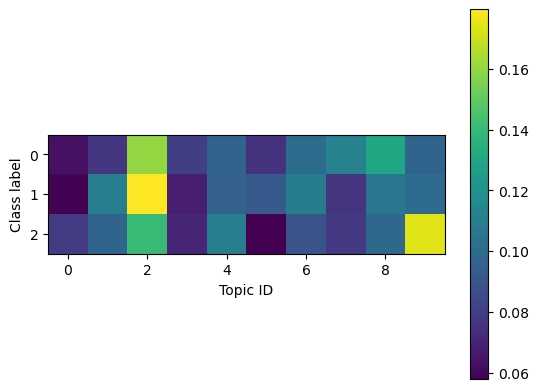

In [27]:
# Merge arrays for later 
arr = test_tweets
arr_2 = test_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_tweet_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_tweet_topic_dists
        thetas_t_sparse = get_tweet_topic_dists(test_tweets[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense_vector(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_tweet_mean_topics()

def plot_tweet_topic_matrix():
    # Get mean tweet topics dists
    mean_thetas = get_tweet_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.xlabel("Topic ID")
    plt.ylabel("Class label")
    plt.show()
plot_tweet_topic_matrix()